# Weible Homework 7

Imports and preferences

In [89]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
from numpy.linalg import norm

# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200

# Computer Modern with TeX
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [92]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename):
        """
        Initializes our AnalyticOrbit object, storing the filename to write to,
        the M31 and M33 COM positions and velocities (incl. relative positions and
        velocities), along with M31 halo, disk, and bulge masses and scale lengths.
        
        Inputs:
            filename : 'str'
                string filename to write our integrated orbit to.
        
        Returns:
            none
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### store the output file name
        self.filename = filename
        
        ### get the current pos/vel of M33 
        # create an instance of the  CenterOfMass class for M33
        # 2 = disk particles
        M33_com = CenterOfMass('M33_000.txt', 2)

        # store the position VECTOR of the M33 COM (.value to get rid of units)
        # tolerance of 0.1 kpc, reduce radius by factor of 4 for stripped M33
        M33_com_p = M33_com.COM_P(0.1, 4) # kpc
        self.M33_com_p = M33_com_p.value # kpc
        
        # store the velocity VECTOR of the M33 COM (.value to get rid of units)
        # need units on position when calling COM_V, so use M33_com_p
        M33_com_v = M33_com.COM_V(*M33_com_p) # km/s
        self.M33_com_v = M33_com_v.value # km/s
        
        ### get the current pos/vel of M31 
        # create an instance of the  CenterOfMass class for M31 
        M31_com = CenterOfMass('M31_000.txt', 2)
        
        # store the position VECTOR of the M31 COM (.value to get rid of units)
        # tolerance of 0.1 kpc, reduce radius by factor of 2 for less-stripped M31
        M31_com_p = M31_com.COM_P(0.1, 2) # kpc
        self.M31_com_p = M31_com_p.value # kpc
        
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        # need units on position when calling COM_V, so use M31_com_p
        M31_com_v = M31_com.COM_V(*M31_com_p) # km/s
        self.M31_com_v = M31_com_v.value# km/s
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = self.M33_com_p - self.M31_com_p
        self.v0 = self.M33_com_v - self.M31_com_v
        
        ### get the mass of each component in M31 
        ### disk
        # self.rdisk = scale length (no units)
        self.rdisk = 5 # kpc

        # self.Mdisk set with ComponentMass function. *1e12 to get the right units.
        # ptype=2 for disk particles
        self.Mdisk = ComponentMass('M31_000.txt', 2).value * 1e12
        
        ### bulge
        # self.rbulge = set scale length (no units)
        self.rbulge = 1 # kpc

        # self.Mbulge  set with ComponentMass function. *1e12 to get the right units.
        # ptype=3 for bulge particles
        self.Mbulge = ComponentMass('M31_000.txt', 3).value * 1e12
        
        # Halo
        # self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62 # kpc

        # self.Mhalo set with ComponentMass function. *1e12 to get the right units.
        # ptype=1 for halo
        self.Mhalo = ComponentMass('M31_000.txt', 1).value * 1e12
    
    
    def HernquistAccel(self, M, r_a, r):
        """
        Computes the acceleration vector from a Hernquist potential,
        which we'll use for our bulges and halos. Takes a Hernquist mass, scale length,
        and the position w.r.t. the potential for the acceleration to be calcualted at.
        
        Inputs:
            M : 'float'
                Halo/bulge mass in MSun for the Hernquist potential
            r_a : 'float'
                Hernquist profile scale length in kpc (from mass profile fit)
            r : 'numpy array'
                Vector of floats, relative position to calculate the acceleration at
                (kpc)
        
        Returns:
            acc : 'numpy array'
                Vector of floats, acceleration vector due to the Hernquist potential
                (kpc/Gyr^2 ~ km/s/Gyr)
        """
        
        ### Store the magnitude of the position vector
        rmag = norm(r)
        
        ### Store the Acceleration vector
        Hern = -self.G * M * r / (rmag * (r_a + rmag)**2)
        
        return Hern
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):
        """
        Computes the acceleration vector from a Miyamoto-Nagai profile,
        while we'll use for the disk. Takens a disk mass, scale radius, and position
        to caclulate the acceleration at. 
        
        Inputs:
             M : 'float'
                Disk mass in MSun
            r_d : 'float'
                Miyamoto-Nagai disk scale length in kpc
            r : 'numpy array'
                Vector of floats, relative position to calculate the acceleration at
                (kpc)
        
         Returns:
            acc : 'numpy array'
                Vector of floats, acceleration vector due to the Miyamoto-Nagai
                potential (kpc/Gyr^2 ~ km/s/Gyr)
        """
        
        # Decompose the position vector
        x = r[0]
        y = r[1]
        z = r[2]
        
        # Miyamoto-Nagai 1975 profile parameters
        z_d  = r_d / 5.0
        R = np.sqrt(x**2 + y**2)
        B = r_d + np.sqrt(z**2 + z_d**2)
        
        # prefactor
        prefac = -self.G * M / (R**2 + B**2)**(1.5)
        
        # put it all together
        acc = prefac * r * np.array([1, 1, B / np.sqrt(z**2 + z_d**2)])
       
        return acc
     
    
    def M31Accel(self, r):
        """
        Computes the total acceleration vector due to all three components of M31
        combined, at position vector r. Takes only the relative position w.r.t. M31.
        
        Inputs:
            r : 'numpy array'
                Vector of floats, relative position to calculate the acceleration at
                (kpc)
            
        Returns:
            acc_sum : 'numpy array'
                Vector of floats, acceleration vector due to all three components of
                M31, at position r (kpc/Gyr^2 ~ km/s/Gyr)
                
        """

        # Call the previous functions for the halo, bulge and disk
        acc_disk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        acc_halo = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        acc_bulge = self.HernquistAccel(self.Mbulge, self.rbulge, r)
            
        # return the SUM of the output of the acceleration functions
        # this will return a VECTOR 
        acc_sum = acc_disk + acc_halo + acc_bulge
        
        return acc_sum
    
    
    def LeapFrog(self, dt, r, v):
        """
        Integrates our galaxy COM equation of motion (d^2r/dt^2 = a) using a
        leapfrog integrator (second order, symplectic, etc. etc.). Takes a time step,
        relative positon, and relative velocity, and returning the next relative
        posion and velocity.
        
        Inputs:
            dt : 'float'
                Integration time step (Gyr)
            r : 'numpy array'
                Vector of floats, relative position of M33 to M31 (kpc)
            v : 'numpy array'
                Vector of floats, relative velocity of M33 to M31 (km/s ~ kpc/Gyr)
                
        Returns:
            rnew : 'numpy array'
                Vector of floats, updated relative position of M33 (kpc)
            vnew : 'numpy array'
                Vector of floats, update velocity of M33 (km/s ~ kpc/Gyr)
            
        """
        
        # predict the position at the next half timestep
        rhalf = r + v * (dt/2)
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf) * dt
        
        # predict the final position using the average of the current velocity and the
        # final velocity. This accounts for the fact that we don't know how the speed
        # changes from the current timestep to the next, so we approximate it using
        # the average expected speed over the time interval dt. 
        rnew = rhalf + vnew * (dt/2)
        
        # return the new position and velocity vectors
        return rnew, vnew
            
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Loops over the LeapFrog method in order to integrate the COM equation of motion
        for M33 around M31 from time t0 until time tmax with time step dt.

        Inputs:
            t0 : 'float'
                Start time for orbit integration (Gyr)
            dt : 'float'
                Time step (Gyr)
            tmax : 'float'
                End time for orbit integration (inclusive) (Gyr)

        """

        # initialize the time to the input starting time
        t = t0
        # initial position and velocity
        r = self.r0
        v = self.v0

        # initialize an empty array of size : rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+3, 7))

        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]


        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1

        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while t < tmax:  # as long as t has not exceeded the maximal time 

            # advance the time by one timestep, dt
            t += dt
            # store the new time in the first column of the ith row
            orbit[i, 0] = t

            # advance the position and velocity using the LeapFrog scheme
            rnew, vnew = self.LeapFrog(dt, r, v)

            # store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 1:4] = rnew

            # store the new velocity vector into the columns with indexes 4,5,6 of the ith row of orbit
            orbit[i, 4:] = vnew

            # update counter i , where i is keeping track of the number of rows
            # (i.e. the number of time steps)
            i += 1

            # Update position and velocity for the next run of the loop.
            r = rnew
            v = vnew
        
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%13.4f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))


# 5 &nbsp; Analysis

## 1.

#### Initialization and integration:

In [112]:
# Integration interval w/time step
t0 = 0.0 # Gyr
tmax = 10.0 # Gyr
dt = 0.00001 # Gyr

# construct a filename with the time interval
filename = 'dt_'+str(dt)+'.txt'

# Integrate the orbit
M33_orbit = M33AnalyticOrbit(filename)
M33_orbit.OrbitIntegration(t0, dt, tmax)

#### Read data and compute:

In [ ]:
# Read in orbit integration data
data = np.genfromtxt(filename, dtype=None, names=True)

# assign to vars and create vectors
t = data['t'] # orbit integration time (Gyr)
# relative position components (kpc)
x, y, z = data['x'], data['y'], data['z']
r = np.array([x, y, z]) # to a vector (kpc)
rmag = norm(r, axis=0) # magnitude (kpc)

# velocity/speed (km/s ~ kpc/Gyr):
vx, vy, vz = data['vx'], data['vy'], data['vz'] # components
v = np.array([vx, vy, vz]) # to a vector
vmag = norm(v, axis=0) # magnitude

# Read in the N-body file for M31 from Homework 6
M31 = np.genfromtxt('Orbit_M31.txt', dtype=None, names=True)

# assign to vars and create vectors:
t_N = M31['t'] # N-body time (Gyr)

# kpc
x_M31, y_M31, z_M31 = M31['x'], M31['y'], M31['z'] # position components
r_M31 = np.array([x_M31, y_M31, z_M31]) # to a vector

# M31 velocity components (km/s ~ kpc/Gyr)
vx_M31, vy_M31, vz_M31 = M31['vx'], M31['vy'], M31['vz']
v_M31 = np.array([vx_M31, vy_M31, vz_M31]) # to a vector

# Read in the N-body file for M33 from Homework 6
M33 = np.genfromtxt('Orbit_M33.txt', dtype=None, names=True)

# assign to vars and create vectors (kpc)
x_M33, y_M33, z_M33 = M33['x'], M33['y'], M33['z'] # position components
r_M33 = np.array([x_M33, y_M33, z_M33]) # to a vector

# M31 velocity components (km/s ~ kpc/Gyr)
vx_M33, vy_M33, vz_M33 = M33['vx'], M33['vy'], M33['vz']
v_M33 = np.array([vx_M33, vy_M33, vz_M33]) # to a vector

# magnitude of differences (relative displacement and speed)
N_rel_rmag = norm(r_M33 - r_M31, axis=0) # kpc
N_rel_vmag = norm(v_M33 - v_M31, axis=0) # km/s ~ kpc/Gyr

### Plot:

Relative separation

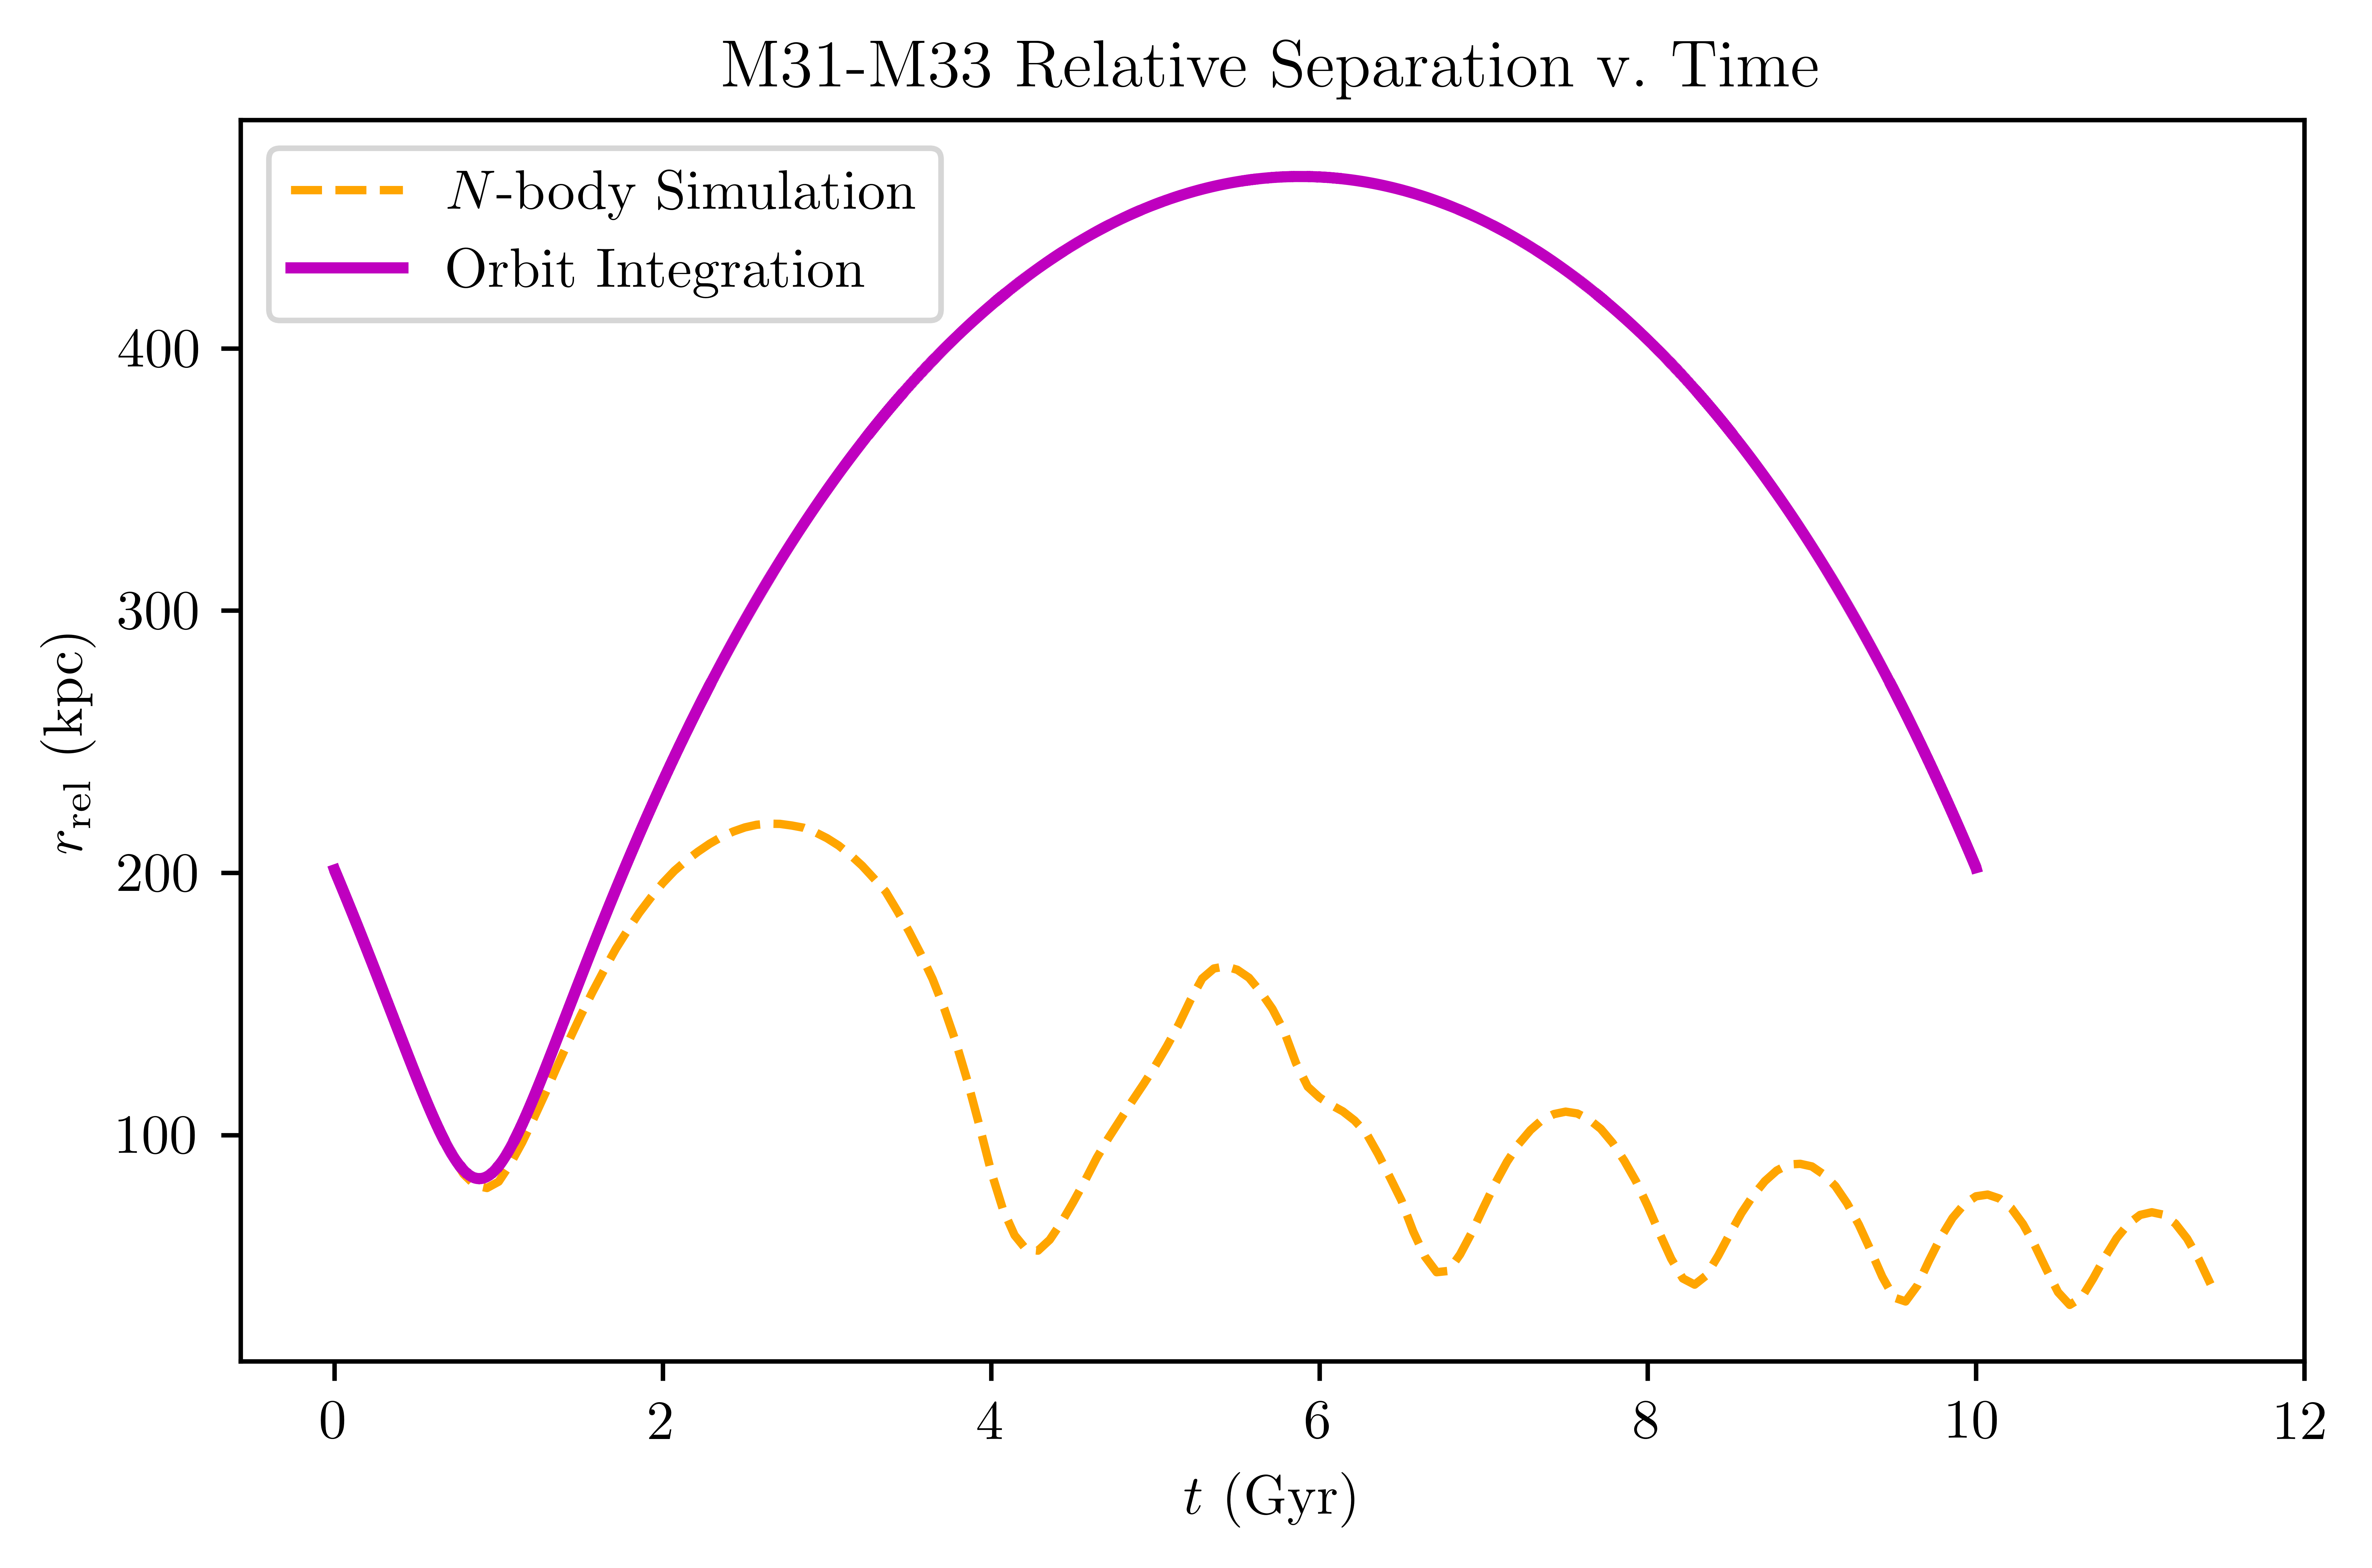

In [129]:
# Plot setup
fig, ax = plt.subplots()

# plot the N-body orbit relative position from HW 6
ax.plot(t_N, N_rel_rmag, color='orange', label=r'$N$-body Simulation', linestyle='--')
# plot the orbit integration relative position
ax.plot(t, rmag, color='m', label=r'Orbit Integration', linewidth=2)

# title, axis labels
ax.set(title=r'M31-M33 Relative Separation v.~Time', xlabel=r'$t \ (\mathrm{Gyr})$',
       ylabel=r'$r_\mathrm{rel} \ (\mathrm{kpc})$')

# legend, tidy things up, and save to a PNG
ax.legend()
fig.tight_layout()
plt.savefig('M31-M33_rel_sep.png', facecolor='w')

Relative Speed

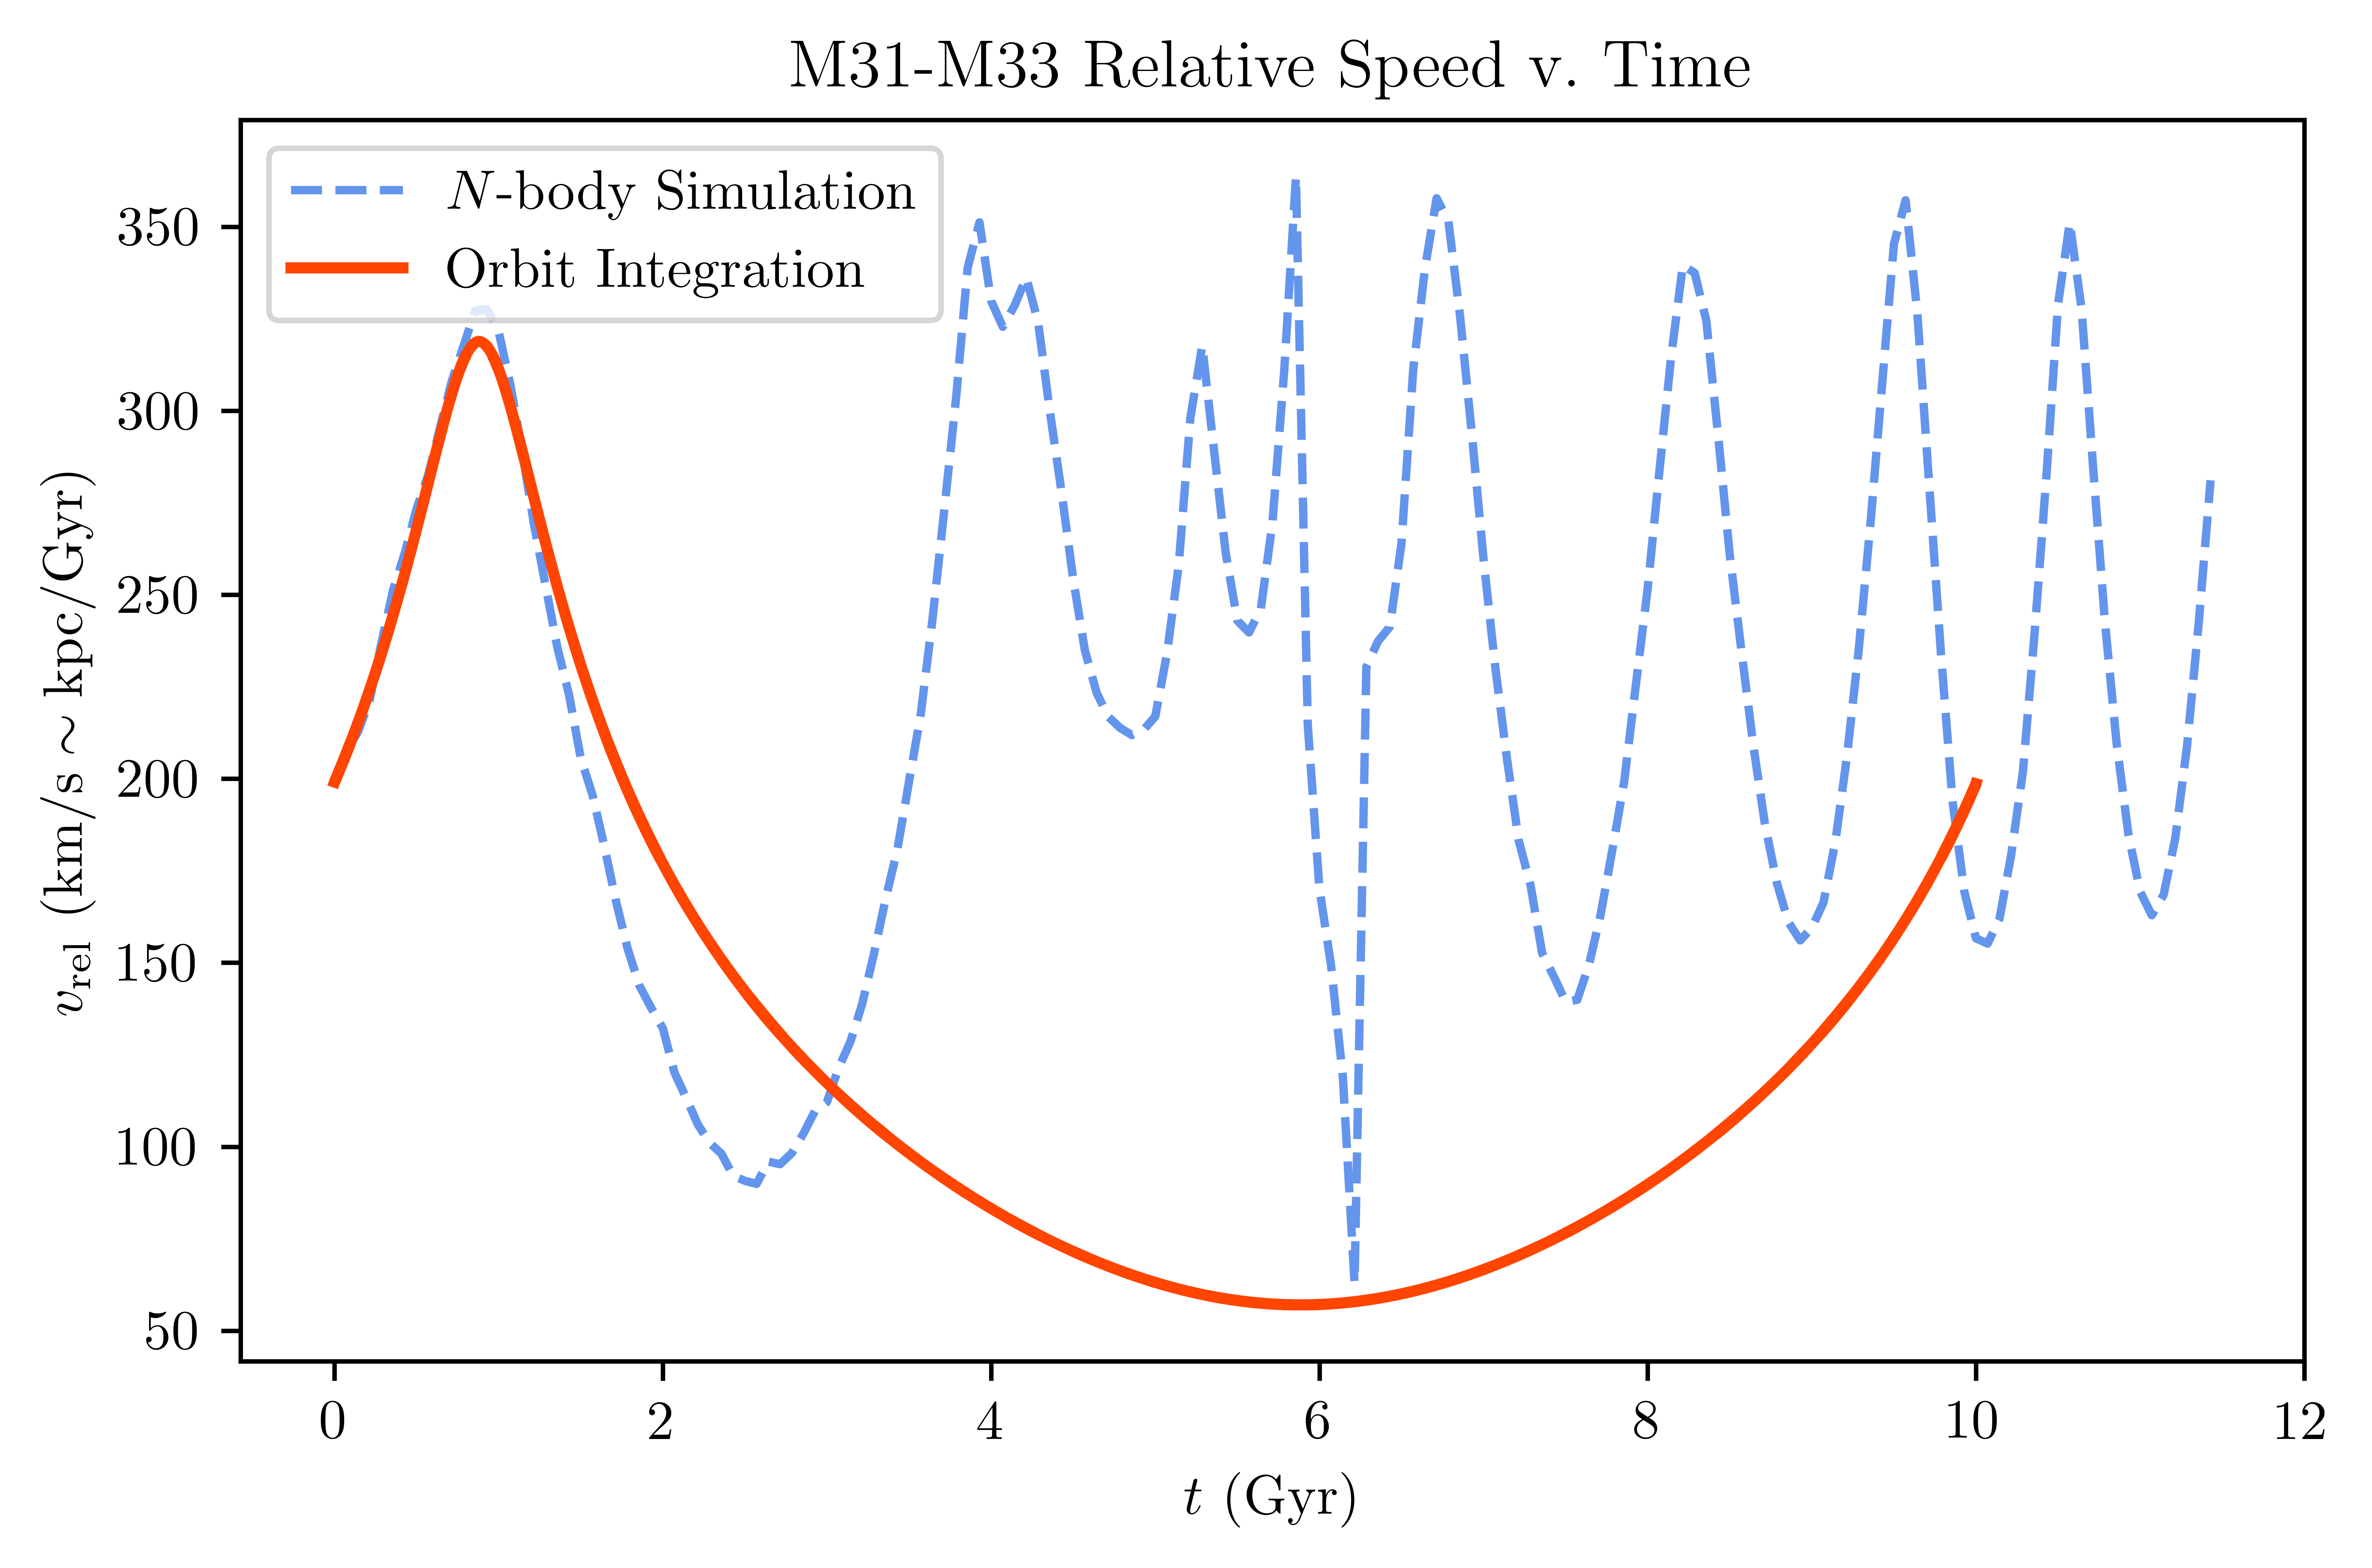

In [128]:
# Plot setup
fig, ax = plt.subplots()

# plot the N-body relative speed from HW 6
ax.plot(t_N, N_rel_vmag, color='cornflowerblue', label=r'$N$-body Simulation',
        linestyle='--')
# plot the orbit integration relative speed
ax.plot(t, vmag, color='orangered', label='Orbit Integration', linewidth=2)

# title and axis labels
ax.set(title=r'M31-M33 Relative Speed v.~Time', xlabel=r'$t \ (\mathrm{Gyr})$',
       ylabel='$v_\mathrm{rel} \ (\mathrm{km}/\mathrm{s} \sim \mathrm{kpc}/\mathrm{Gyr})$')

# legend, tidy things up, and save to a PNG
ax.legend()
fig.tight_layout()
plt.savefig('M31-M33_rel_vel.png', facecolor='w')

## 2.

The two methods of orbit simulation agree well for the first ${\sim}1.5$ Gyr or so, before diverging. The semi-analytic orbit integration predicts a single pericenter-apocenter pair in the next 10 Gyr for the M31-M33 system, while the $N$-body simulation gives ${\sim}5$ such pairs in the next 10 Gyr. The semi-analytic integration gives a much larger apocenter at ${\sim}6$ Gyr than any of those predicted by the $N$-body simulation. The semi-analytic integration shows M33 being flung out further from M31 into a longer-period orbit.

## 3.

We do not have any dynamical friction present in the semi-analytic orbit integration, as we do not actually model dark matter particles and their motions, just a constant Hernquist profile for M31. This would help to explain the damping present in the $N$-body simulation's relative position. I think that this is the main bit of physics that would serve to bring M33 closer and onto a shorter- and shortenting-period orbit were it accounted for in the semi-analytic approach. Somewhere energy is being removed from M33, and it makes sense for this to be from dynamical friction.

## 4.

We could model the MW similarly to M31, with idealized bulge, disk, and halo potentials, along with its initial conditions in the M31 COM frame from the $N$-body simulation. This is then a (restricted) 3-body problem and we should account for the acceleration of M33 due to the MW, as well as the acceleration of the MW due to M31 (i.e., stay in the M31 COM frame, and don't model the force on the MW from M33, though we could if we wanted to). I imagine that there would be issues here during the merger though, where we may get infinities from the COM positions of the MW and M31 getting very close. Maybe a softening length could be added, and/or once the two big galaxies come close enough (but not too close), the remnant could then be modeled as a single more-or-less elliptical galaxy with associated idealized potential(s). I'm not really sure I like this idea though, because the more we rely on the results of a single $N$-body simulation derived from a single choice of initial conditions compatible with observations the less informative the semi-analytic integration is for exploring the range of compatible initital conditions. On the other hand, we might still be able to learn something about the subset of compatible initial conditions that do lead to a merger by doing this.